In [1]:
import torch

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [3]:
df_names = pd.read_csv('data/features.txt', header=None)

In [4]:
names = df_names[0]

In [5]:
idxs = []

for i, name in enumerate(names):
    #if 'Mean' in name or 'STD' in name:
    idxs.append(i)

In [6]:
def load_data(path, idxs, type_="train"):
    data_path = path + "/T" + type_[1:] + "/X_" + type_ + ".txt"
    labels_path = path + "/T" + type_[1:] + "/y_" + type_ + ".txt"
    subjects_path = path + "/T" + type_[1:] + "/subject_id_" + type_ + ".txt"
    
    data = pd.read_csv(data_path, sep=" ", header=None)
    labels = pd.read_csv(labels_path, sep=" ", header=None)
    subjects = pd.read_csv(subjects_path, sep=" ", header=None)
    
    data = data[idxs]
    
    data["subject"] = subjects
    data["labels"] = labels
    
    return data

In [7]:
def find_change(array):
    count_ = 0
    changes = []
    len_ = len(array)
    for i in range(len_):             
        if i < len_-3:
            value_current = array[i]
            value_ahead = array[i+1]

            if value_current!=value_ahead:
                changes.append(i)
    return changes


def find_idx(data):
    subjects = np.unique(data.subject)
    changes_global = np.array([])
    for subject in subjects:
        local = data[data.subject==subject]
        local = local.reset_index(drop=True)

        changes_ = find_change(local.labels)
        changes_ = np.append([0], changes_)
        start = 0
        len_ = len(changes_)
        changes_local = np.array([])
        while True:
            changes_local = np.append(changes_local, changes_[start:start+4])
            start += 2
            if start > len_-4:
                break
        changes_global = np.append(changes_global, changes_local)       
    return changes_global


def prepare_idx(changes_global):
    max_len = 20
    
    changes_global = changes_global.reshape(changes_global.shape[0]//4, 4)
    changes_global[:, 0] += 1
    changes_global[0, 0] -= 1
    
    changes_global_final = []   

    for i, change in enumerate(changes_global):
        len_ = change[3] - change[0]
        diff = len_ - max_len
        if diff > 0:
            if ((changes_global[i][1]-changes_global[i][0])<max_len) and (changes_global[i][1]-changes_global[i][0])>0:
                changes_global_final.append([changes_global[i][0], changes_global[i][1], changes_global[i][2], changes_global[i][0] + max_len])

    return changes_global_final


def prepare_data(data, changes_global_final):
    max_len = int(changes_global_final[0][3] - changes_global_final[0][0])
    train_set = torch.tensor([])

    for i, change in enumerate(changes_global_final):
        start, end = int(change[0]), int(change[3])
        element = data[start:end].to_numpy()[:, :len(idxs)]
        if len(train_set) == 0:
            train_set = torch.tensor(element)
        else:
            train_set = torch.cat([train_set, torch.tensor(element)])
            
    train_set = train_set.reshape(len(train_set)//max_len, max_len, len(idxs))
    return train_set


def prepare_labels(changes_global_final):
    labels = []
    max_len = int(changes_global_final[0][3] - changes_global_final[0][0])
    for change in changes_global_final:
        position = int(change[1]-change[0])
        labels_local = np.append(np.zeros(position), np.ones(max_len-position))
        labels.append(labels_local)
    return torch.tensor(labels, dtype=torch.int)

def preprocess(data):
    changes_global = find_idx(data)
    changes_global_final = prepare_idx(changes_global)
    set_ = prepare_data(data, changes_global_final)
    labels = prepare_labels(changes_global_final)
    return set_, labels

In [8]:
!nvidia-smi

Thu May 27 17:07:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:03:00.0 Off |                  N/A |
| 66%   83C    P2   109W / 280W |  23157MiB / 24219MiB |     19%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:04:00.0 Off |                  N/A |
| 41%   52C    P2    71W / 280W |  14490MiB / 24220MiB |     20%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [9]:
%%time

data_train = load_data("./data", idxs, type_="train")
train_features, train_labels = preprocess(data_train)

data_test = load_data("./data/", idxs, type_="test")
test_features, test_labels = preprocess(data_test)

CPU times: user 24.4 s, sys: 1.89 s, total: 26.3 s
Wall time: 4.21 s


In [10]:
all_data = np.vstack((train_features, test_features))
all_labels = np.vstack((train_labels, test_labels))

In [11]:
all_data.shape

(319, 20, 561)

In [12]:
train_data, test_data, train_labels, test_labels = train_test_split(all_data, all_labels, 
                                                                    test_size=0.2, shuffle=True,
                                                                    random_state=42)

test_data, val_data, test_labels, val_labels = train_test_split(test_data, test_labels, 
                                                                test_size=0.5, shuffle=True,
                                                                random_state=42)

In [13]:
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(255, 20, 561)
(32, 20, 561)
(32, 20, 561)


In [14]:
!nvidia-smi

Thu May 27 17:07:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:03:00.0 Off |                  N/A |
| 66%   83C    P2   133W / 280W |  23157MiB / 24219MiB |     33%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:04:00.0 Off |                  N/A |
| 41%   52C    P2    70W / 280W |  14490MiB / 24220MiB |     20%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [15]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device('cuda:0')

In [16]:
def loss_delay_detection_2(p_slice):
    n = p_slice.size(0)
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    prod[1:] -= p_slice[:-1]
    cumprod = torch.cumprod(prod, dim=0).to(device)
    loss = torch.arange(1, n + 1).to(device) * p_slice * cumprod
    loss = torch.sum(loss)
    return loss


def loss_delay_detection(p_slice, w):
    n = p_slice.size(0) 
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    
    prod[1:] -= p_slice[:-1].to(device)
    cumprod = torch.cumprod(prod, dim=0).to(device)
    # TODO drop either n or w
    loss = (torch.arange(1, n + 1).to(device) * p_slice * cumprod 
            + (w + 1) * torch.prod(prod[1:]) * (1 - p_slice[-1]))
    loss = torch.sum(loss)
    return loss

def loss_false_alarms(p_slice):
    length = len(p_slice)
    loss = 0
    
    start_ind = 0
    end_ind = 0

    #mb it should be recommented
    
    while end_ind < length:
        start_ind = end_ind - 1
        if start_ind < 0:
            start_ind = 0
        end_ind = np.random.randint(start_ind, length + 2)
        if end_ind == start_ind:
            end_ind = end_ind + 1
        loss += 1 - loss_delay_detection_2(p_slice[start_ind: end_ind + 1])

    #loss += 1 - loss_delay_detection_2(p_slice[start_ind: length])            
    loss = torch.sum(loss)
    return loss

In [17]:
class CustomLoss(nn.Module):
    
    def __init__(self):
        super(CustomLoss, self).__init__()
        
    def forward(self, outputs, labels):
        loss = torch.zeros(labels.size(0))
        for i, label in enumerate(labels):
            ind = torch.where(label != label[0])[0]
            if ind.size()[0] == 0:
                loss[i] = loss_false_alarms(outputs[i, :])
            else:
                #w = 5
                w = 10
                alpha = 0.5
                loss[i] = (alpha * loss_delay_detection(outputs[i, ind[0]:(ind[0] + w)], w) + 
                           (1 - alpha) * loss_false_alarms(outputs[i, :ind[0]]))
        loss = torch.mean(loss)
        return loss

In [18]:
SEQ_LEN = 20

In [19]:
# input data parameters
input_size = 561
output_size = SEQ_LEN
seq_len = SEQ_LEN

# model hyperparameters
hidden_dim = 8
n_layers = 2
num_workers = 1
learning_rate = 1e-3

batch_size = 16

In [20]:
def prepare_loader(data, labels, seq_len, input_size, batch_size, shuffle=True, num_workers=1):
    data = torch.FloatTensor(data)
    labels = torch.FloatTensor(labels)
    data = data.view(-1, seq_len, input_size)
    labels = labels.view(-1, seq_len)

    all_data = TensorDataset(data, labels) 
    data_loader = DataLoader(all_data, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    
    return data_loader

In [21]:
train_loader = prepare_loader(train_data, train_labels, seq_len, input_size, batch_size)
val_loader = prepare_loader(val_data, val_labels, seq_len, input_size, batch_size, shuffle=False)
test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, batch_size, shuffle=False)

In [22]:
def train_model(model, loss_function, epochs=100, print_every=30, LSTM_flag=False, RNN_flag=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    valid_loss_min = np.Inf

    loss_list = []
    acc_list = []
    overall_val_loss_list = []
    counter = 0
    model.train()

    out_list = []
    labels_list = []

    model.train()
    for i in range(epochs):
        # for inputs, labels in tqdm(train_loader):
        for inputs, labels in train_loader:
            if inputs.shape[0] < batch_size:
                break

            counter += 1
            inputs, labels = inputs.to(device), labels.to(device)  

            if LSTM_flag:
                h = model.init_hidden(batch_size)
                h = tuple([e.data for e in h])
                output, h = model(inputs, h)
            elif RNN_flag:
                h = model.init_hidden(batch_size)
                h = torch.stack([e.data for e in h])
                h = torch.zeros(2, batch_size, hidden_dim).to(device)
                output, h = model(inputs, h)                
            else:
                output = model(inputs)

            loss = loss_function(output.squeeze(), labels.float())
            loss_list += [loss.cpu().clone().detach()]
            accuracy = (output > 0.5).long() == labels
            acc_list += [accuracy.cpu().detach().float().mean()]
            out_list.append(output.cpu().detach().float())
            labels_list.append(labels.cpu().detach().float())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if counter%print_every == 0:
                val_losses = []
                val_outputs = []
                model.eval()
                for val_inputs, val_labels in val_loader:
                    if val_inputs.shape[0] < batch_size:
                        break
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                    if LSTM_flag:
                        val_h = model.init_hidden(batch_size)
                        val_h = tuple([each.data for each in val_h])
                        val_out, val_h = model(val_inputs, val_h)
                    elif RNN_flag:
                        val_h = model.init_hidden(batch_size)
                        val_h = torch.stack([each.data for each in val_h])
                        val_h = torch.zeros(2, batch_size, hidden_dim).to(device)
                        val_out, val_h = model(val_inputs, val_h)
                    else:
                        val_out = model(val_inputs)
                        
                    val_loss = loss_function(val_out.squeeze(), val_labels.float())
                    val_losses.append(val_loss.item())
                    val_outputs += [val_out.cpu().clone().detach()]

                val_outputs_one = torch.cat(val_outputs, 0)

                overall_val_loss_list.append(np.mean(val_losses))

                model.train()
                print("Epoch: {}/{}...".format(i+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(val_losses)))
    return model, (loss_list, acc_list, overall_val_loss_list)

In [23]:
!rm -rf experiments
!mkdir experiments

### LSTM Model

In [24]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.1):
        
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim        
        # if batch_first, than shape of lstm_in: [batch_size, seq_len, input_size]
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.linear_1 = nn.Linear(hidden_dim, hidden_dim//2)
        self.linear_2 = nn.Linear(hidden_dim//2, 1)
        self.activation = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, input_seq, hidden):
        batch_size = input_seq.size(0)
        lstm_out, hidden = self.lstm(input_seq, hidden)  
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)      
        out = self.linear_1(lstm_out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.linear_2(out)
        out = self.activation(out)
        out = out.view(batch_size, -1)

        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [25]:
model_LSTM_custom = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
loss_function = CustomLoss()
model_LSTM_custom.to(device)

LSTM(
  (lstm): LSTM(561, 8, num_layers=2, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear_1): Linear(in_features=8, out_features=4, bias=True)
  (linear_2): Linear(in_features=4, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [26]:
model_LSTM_custom, (loss_list, acc_list, 
                    overall_val_loss_list) = train_model(model_LSTM_custom, loss_function, 60, 5, LSTM_flag=True)

model_LSTM_custom = model_LSTM_custom.eval() 
torch.save(model_LSTM_custom, "experiments/model_LSTM_custom.pth")

Epoch: 1/60... Step: 5... Loss: 0.459274... Val Loss: 0.765682
Epoch: 1/60... Step: 10... Loss: 0.879239... Val Loss: 0.639100
Epoch: 1/60... Step: 15... Loss: 0.509794... Val Loss: 0.713530
Epoch: 2/60... Step: 20... Loss: 0.542528... Val Loss: 0.602939
Epoch: 2/60... Step: 25... Loss: 0.420408... Val Loss: 0.661616
Epoch: 2/60... Step: 30... Loss: 0.592959... Val Loss: 0.700142
Epoch: 3/60... Step: 35... Loss: 0.658001... Val Loss: 0.756287
Epoch: 3/60... Step: 40... Loss: 0.589457... Val Loss: 0.655842
Epoch: 3/60... Step: 45... Loss: 0.557816... Val Loss: 0.650870
Epoch: 4/60... Step: 50... Loss: 0.357644... Val Loss: 0.618097
Epoch: 4/60... Step: 55... Loss: 0.267986... Val Loss: 0.523543
Epoch: 4/60... Step: 60... Loss: 0.381603... Val Loss: 0.605612
Epoch: 5/60... Step: 65... Loss: 0.323231... Val Loss: 0.593015
Epoch: 5/60... Step: 70... Loss: 0.469546... Val Loss: 0.504456
Epoch: 5/60... Step: 75... Loss: 0.512732... Val Loss: 0.435282
Epoch: 6/60... Step: 80... Loss: 0.520799

Epoch: 42/60... Step: 625... Loss: -0.075444... Val Loss: -0.090123
Epoch: 42/60... Step: 630... Loss: -0.139743... Val Loss: -0.114498
Epoch: 43/60... Step: 635... Loss: -0.233495... Val Loss: -0.073922
Epoch: 43/60... Step: 640... Loss: -0.239090... Val Loss: -0.085132
Epoch: 43/60... Step: 645... Loss: -0.297899... Val Loss: -0.215272
Epoch: 44/60... Step: 650... Loss: -0.336591... Val Loss: -0.139399
Epoch: 44/60... Step: 655... Loss: -0.140778... Val Loss: -0.137836
Epoch: 44/60... Step: 660... Loss: -0.168681... Val Loss: -0.065227
Epoch: 45/60... Step: 665... Loss: -0.227649... Val Loss: -0.077041
Epoch: 45/60... Step: 670... Loss: -0.316598... Val Loss: -0.087826
Epoch: 45/60... Step: 675... Loss: -0.236110... Val Loss: -0.133915
Epoch: 46/60... Step: 680... Loss: -0.277519... Val Loss: -0.109300
Epoch: 46/60... Step: 685... Loss: -0.407368... Val Loss: -0.128291
Epoch: 46/60... Step: 690... Loss: -0.230893... Val Loss: -0.138054
Epoch: 47/60... Step: 695... Loss: -0.318350... 

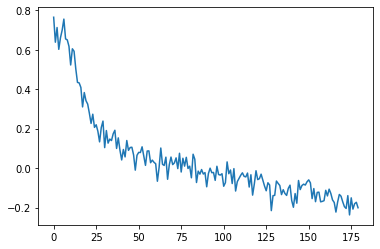

In [27]:
plt.plot(overall_val_loss_list)

In [28]:
model_LSTM_bce = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
bce_loss_function = torch.nn.BCELoss()
model_LSTM_bce.to(device)

LSTM(
  (lstm): LSTM(561, 8, num_layers=2, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear_1): Linear(in_features=8, out_features=4, bias=True)
  (linear_2): Linear(in_features=4, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [29]:
model_LSTM_bce, (bce_loss_list, bce_acc_list, bce_overall_val_loss_list) = train_model(model_LSTM_bce, bce_loss_function, 
                                                                                       60, 5, LSTM_flag=True)
model_LSTM_bce = model_LSTM_bce.eval()
torch.save(model_LSTM_bce, "experiments/model_LSTM_bce.pth")

Epoch: 1/60... Step: 5... Loss: 0.732765... Val Loss: 0.704243
Epoch: 1/60... Step: 10... Loss: 0.687700... Val Loss: 0.702715
Epoch: 1/60... Step: 15... Loss: 0.684406... Val Loss: 0.701277
Epoch: 2/60... Step: 20... Loss: 0.699189... Val Loss: 0.699268
Epoch: 2/60... Step: 25... Loss: 0.691094... Val Loss: 0.696516
Epoch: 2/60... Step: 30... Loss: 0.652068... Val Loss: 0.694743
Epoch: 3/60... Step: 35... Loss: 0.681925... Val Loss: 0.691611
Epoch: 3/60... Step: 40... Loss: 0.693460... Val Loss: 0.688321
Epoch: 3/60... Step: 45... Loss: 0.659526... Val Loss: 0.684431
Epoch: 4/60... Step: 50... Loss: 0.665914... Val Loss: 0.682606
Epoch: 4/60... Step: 55... Loss: 0.691351... Val Loss: 0.677935
Epoch: 4/60... Step: 60... Loss: 0.655279... Val Loss: 0.673395
Epoch: 5/60... Step: 65... Loss: 0.659773... Val Loss: 0.669450
Epoch: 5/60... Step: 70... Loss: 0.645609... Val Loss: 0.664053
Epoch: 5/60... Step: 75... Loss: 0.640501... Val Loss: 0.659828
Epoch: 6/60... Step: 80... Loss: 0.643074

Epoch: 42/60... Step: 630... Loss: 0.364731... Val Loss: 0.467674
Epoch: 43/60... Step: 635... Loss: 0.451874... Val Loss: 0.471852
Epoch: 43/60... Step: 640... Loss: 0.389228... Val Loss: 0.469366
Epoch: 43/60... Step: 645... Loss: 0.347389... Val Loss: 0.470871
Epoch: 44/60... Step: 650... Loss: 0.333152... Val Loss: 0.462607
Epoch: 44/60... Step: 655... Loss: 0.457561... Val Loss: 0.468838
Epoch: 44/60... Step: 660... Loss: 0.323978... Val Loss: 0.470878
Epoch: 45/60... Step: 665... Loss: 0.326352... Val Loss: 0.475189
Epoch: 45/60... Step: 670... Loss: 0.401091... Val Loss: 0.481741
Epoch: 45/60... Step: 675... Loss: 0.329684... Val Loss: 0.473300
Epoch: 46/60... Step: 680... Loss: 0.443038... Val Loss: 0.460256
Epoch: 46/60... Step: 685... Loss: 0.355063... Val Loss: 0.454589
Epoch: 46/60... Step: 690... Loss: 0.365359... Val Loss: 0.468030
Epoch: 47/60... Step: 695... Loss: 0.378401... Val Loss: 0.474173
Epoch: 47/60... Step: 700... Loss: 0.327341... Val Loss: 0.477186
Epoch: 47/

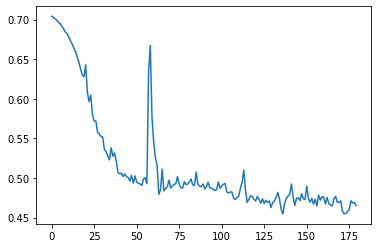

In [30]:
plt.plot(bce_overall_val_loss_list)

In [31]:
model_LSTM_combined = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
first_bce_loss_function = torch.nn.BCELoss()
second_custom_loss_function = CustomLoss()
model_LSTM_combined.to(device)

LSTM(
  (lstm): LSTM(561, 8, num_layers=2, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear_1): Linear(in_features=8, out_features=4, bias=True)
  (linear_2): Linear(in_features=4, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [32]:
model_LSTM_combined, _ = train_model(model_LSTM_combined, first_bce_loss_function, 60, 5, 
                                    LSTM_flag=True)

model_LSTM_combined, _ = train_model(model_LSTM_combined, second_custom_loss_function, 60, 5, 
                                    LSTM_flag=True)


model_LSTM_combined = model_LSTM_combined.eval()
torch.save(model_LSTM_combined, "experiments/model_LSTM_combined.pth")

Epoch: 1/60... Step: 5... Loss: 0.732445... Val Loss: 0.725502
Epoch: 1/60... Step: 10... Loss: 0.757601... Val Loss: 0.720869
Epoch: 1/60... Step: 15... Loss: 0.710097... Val Loss: 0.718263
Epoch: 2/60... Step: 20... Loss: 0.725650... Val Loss: 0.716214
Epoch: 2/60... Step: 25... Loss: 0.693449... Val Loss: 0.713892
Epoch: 2/60... Step: 30... Loss: 0.712585... Val Loss: 0.712377
Epoch: 3/60... Step: 35... Loss: 0.735174... Val Loss: 0.710840
Epoch: 3/60... Step: 40... Loss: 0.694825... Val Loss: 0.709004
Epoch: 3/60... Step: 45... Loss: 0.703573... Val Loss: 0.707280
Epoch: 4/60... Step: 50... Loss: 0.749865... Val Loss: 0.705616
Epoch: 4/60... Step: 55... Loss: 0.715372... Val Loss: 0.703892
Epoch: 4/60... Step: 60... Loss: 0.689111... Val Loss: 0.702683
Epoch: 5/60... Step: 65... Loss: 0.724039... Val Loss: 0.699931
Epoch: 5/60... Step: 70... Loss: 0.685911... Val Loss: 0.697744
Epoch: 5/60... Step: 75... Loss: 0.707884... Val Loss: 0.696780
Epoch: 6/60... Step: 80... Loss: 0.677861

Epoch: 42/60... Step: 630... Loss: 0.327579... Val Loss: 0.460507
Epoch: 43/60... Step: 635... Loss: 0.459519... Val Loss: 0.472212
Epoch: 43/60... Step: 640... Loss: 0.363263... Val Loss: 0.458968
Epoch: 43/60... Step: 645... Loss: 0.304399... Val Loss: 0.466506
Epoch: 44/60... Step: 650... Loss: 0.393624... Val Loss: 0.476401
Epoch: 44/60... Step: 655... Loss: 0.440830... Val Loss: 0.484859
Epoch: 44/60... Step: 660... Loss: 0.237681... Val Loss: 0.467940
Epoch: 45/60... Step: 665... Loss: 0.417982... Val Loss: 0.461914
Epoch: 45/60... Step: 670... Loss: 0.283394... Val Loss: 0.461048
Epoch: 45/60... Step: 675... Loss: 0.338137... Val Loss: 0.476445
Epoch: 46/60... Step: 680... Loss: 0.383332... Val Loss: 0.470950
Epoch: 46/60... Step: 685... Loss: 0.297157... Val Loss: 0.475296
Epoch: 46/60... Step: 690... Loss: 0.312555... Val Loss: 0.469948
Epoch: 47/60... Step: 695... Loss: 0.431587... Val Loss: 0.461914
Epoch: 47/60... Step: 700... Loss: 0.335774... Val Loss: 0.468841
Epoch: 47/

Epoch: 23/60... Step: 345... Loss: -1.246063... Val Loss: -0.770089
Epoch: 24/60... Step: 350... Loss: -1.197128... Val Loss: -0.824558
Epoch: 24/60... Step: 355... Loss: -1.318441... Val Loss: -0.962127
Epoch: 24/60... Step: 360... Loss: -1.752049... Val Loss: -0.841050
Epoch: 25/60... Step: 365... Loss: -1.283971... Val Loss: -0.359131
Epoch: 25/60... Step: 370... Loss: -0.569437... Val Loss: -1.031260
Epoch: 25/60... Step: 375... Loss: -1.195336... Val Loss: -0.804721
Epoch: 26/60... Step: 380... Loss: -0.607456... Val Loss: -0.855359
Epoch: 26/60... Step: 385... Loss: -1.133172... Val Loss: -0.591889
Epoch: 26/60... Step: 390... Loss: -1.258873... Val Loss: -0.694306
Epoch: 27/60... Step: 395... Loss: -1.539899... Val Loss: -0.884515
Epoch: 27/60... Step: 400... Loss: -1.763589... Val Loss: -0.712510
Epoch: 27/60... Step: 405... Loss: -1.738167... Val Loss: -0.893664
Epoch: 28/60... Step: 410... Loss: -1.049682... Val Loss: -0.675519
Epoch: 28/60... Step: 415... Loss: -1.302135... 

### GRU

In [43]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        
        super(GRU, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim        
        # if batch_first, than shape of lstm_in: [batch_size, seq_len, input_size]
        self.gru = nn.GRU(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.linear_1 = nn.Linear(hidden_dim, hidden_dim//2)
        self.linear_2 = nn.Linear(hidden_dim//2, 1)
        self.activation = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, input_seq, hidden):
        batch_size = input_seq.size(0)
        gru_out, hidden = self.gru(input_seq, hidden)  
        gru_out = gru_out.contiguous().view(-1, self.hidden_dim)      
        out = self.linear_1(gru_out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.linear_2(out)
        out = self.activation(out)
        out = out.view(batch_size, -1)

        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [44]:
model_GRU_custom = GRU(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
loss_function = CustomLoss()
model_GRU_custom.to(device)

GRU(
  (gru): GRU(561, 8, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=8, out_features=4, bias=True)
  (linear_2): Linear(in_features=4, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [45]:
model_GRU_custom, (loss_list, acc_list, 
                    overall_val_loss_list) = train_model(model_GRU_custom, loss_function, 60, 5, RNN_flag=True)

model_GRU_custom = model_GRU_custom.eval()
torch.save(model_GRU_custom, "experiments/model_GRU_custom.pth")

Epoch: 1/60... Step: 5... Loss: 0.491030... Val Loss: 0.644904
Epoch: 1/60... Step: 10... Loss: 0.165217... Val Loss: 0.513966
Epoch: 1/60... Step: 15... Loss: 0.443486... Val Loss: 0.517522
Epoch: 2/60... Step: 20... Loss: 0.392902... Val Loss: 0.501265
Epoch: 2/60... Step: 25... Loss: 0.465428... Val Loss: 0.468453
Epoch: 2/60... Step: 30... Loss: 0.506785... Val Loss: 0.478707
Epoch: 3/60... Step: 35... Loss: 0.210334... Val Loss: 0.413860
Epoch: 3/60... Step: 40... Loss: 0.436197... Val Loss: 0.458811
Epoch: 3/60... Step: 45... Loss: 0.360821... Val Loss: 0.347725
Epoch: 4/60... Step: 50... Loss: 0.387267... Val Loss: 0.394271
Epoch: 4/60... Step: 55... Loss: 0.216249... Val Loss: 0.325857
Epoch: 4/60... Step: 60... Loss: 0.334832... Val Loss: 0.388347
Epoch: 5/60... Step: 65... Loss: 0.084153... Val Loss: 0.318454
Epoch: 5/60... Step: 70... Loss: 0.090094... Val Loss: 0.358751
Epoch: 5/60... Step: 75... Loss: 0.220313... Val Loss: 0.287187
Epoch: 6/60... Step: 80... Loss: 0.201669

Epoch: 42/60... Step: 620... Loss: -0.669049... Val Loss: -0.716753
Epoch: 42/60... Step: 625... Loss: -0.688690... Val Loss: -0.722312
Epoch: 42/60... Step: 630... Loss: -1.159294... Val Loss: -0.685945
Epoch: 43/60... Step: 635... Loss: -0.308390... Val Loss: -0.855747
Epoch: 43/60... Step: 640... Loss: -1.045375... Val Loss: -0.933043
Epoch: 43/60... Step: 645... Loss: -0.992357... Val Loss: -0.788438
Epoch: 44/60... Step: 650... Loss: -0.749338... Val Loss: -0.649790
Epoch: 44/60... Step: 655... Loss: -0.411557... Val Loss: -0.870463
Epoch: 44/60... Step: 660... Loss: -0.804662... Val Loss: -0.881473
Epoch: 45/60... Step: 665... Loss: -0.498298... Val Loss: -0.889844
Epoch: 45/60... Step: 670... Loss: -1.094091... Val Loss: -0.573149
Epoch: 45/60... Step: 675... Loss: -0.334674... Val Loss: -0.684812
Epoch: 46/60... Step: 680... Loss: -1.132460... Val Loss: -0.701872
Epoch: 46/60... Step: 685... Loss: -0.977543... Val Loss: -0.770630
Epoch: 46/60... Step: 690... Loss: -1.125057... 

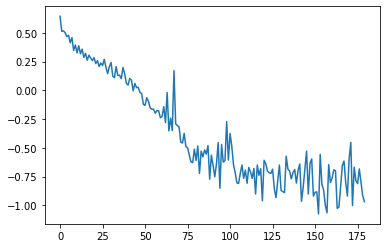

In [46]:
plt.plot(overall_val_loss_list)

In [47]:
model_GRU_bce = GRU(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
bce_loss_function = torch.nn.BCELoss()
model_GRU_bce.to(device)

GRU(
  (gru): GRU(561, 8, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=8, out_features=4, bias=True)
  (linear_2): Linear(in_features=4, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [48]:
model_GRU_bce, (bce_loss_list, bce_acc_list, bce_overall_val_loss_list) = train_model(model_GRU_bce, bce_loss_function, 
                                                                                       60, 5, RNN_flag=True)

model_GRU_bce = model_GRU_bce.eval()
torch.save(model_GRU_bce, "experiments/model_GRU_bce.pth")

Epoch: 1/60... Step: 5... Loss: 0.689611... Val Loss: 0.704868
Epoch: 1/60... Step: 10... Loss: 0.710219... Val Loss: 0.704842
Epoch: 1/60... Step: 15... Loss: 0.722485... Val Loss: 0.703613
Epoch: 2/60... Step: 20... Loss: 0.715908... Val Loss: 0.701692
Epoch: 2/60... Step: 25... Loss: 0.706653... Val Loss: 0.700170
Epoch: 2/60... Step: 30... Loss: 0.703221... Val Loss: 0.697753
Epoch: 3/60... Step: 35... Loss: 0.693850... Val Loss: 0.695895
Epoch: 3/60... Step: 40... Loss: 0.677976... Val Loss: 0.693830
Epoch: 3/60... Step: 45... Loss: 0.680990... Val Loss: 0.691367
Epoch: 4/60... Step: 50... Loss: 0.682626... Val Loss: 0.689617
Epoch: 4/60... Step: 55... Loss: 0.703577... Val Loss: 0.686223
Epoch: 4/60... Step: 60... Loss: 0.669863... Val Loss: 0.683335
Epoch: 5/60... Step: 65... Loss: 0.659730... Val Loss: 0.680765
Epoch: 5/60... Step: 70... Loss: 0.664564... Val Loss: 0.677996
Epoch: 5/60... Step: 75... Loss: 0.662179... Val Loss: 0.675949
Epoch: 6/60... Step: 80... Loss: 0.681190

Epoch: 42/60... Step: 630... Loss: 0.469968... Val Loss: 0.481645
Epoch: 43/60... Step: 635... Loss: 0.464935... Val Loss: 0.487991
Epoch: 43/60... Step: 640... Loss: 0.418518... Val Loss: 0.481152
Epoch: 43/60... Step: 645... Loss: 0.511802... Val Loss: 0.483901
Epoch: 44/60... Step: 650... Loss: 0.490149... Val Loss: 0.483422
Epoch: 44/60... Step: 655... Loss: 0.422395... Val Loss: 0.482735
Epoch: 44/60... Step: 660... Loss: 0.399299... Val Loss: 0.480286
Epoch: 45/60... Step: 665... Loss: 0.456020... Val Loss: 0.481113
Epoch: 45/60... Step: 670... Loss: 0.417604... Val Loss: 0.477250
Epoch: 45/60... Step: 675... Loss: 0.432556... Val Loss: 0.477738
Epoch: 46/60... Step: 680... Loss: 0.427534... Val Loss: 0.476817
Epoch: 46/60... Step: 685... Loss: 0.421689... Val Loss: 0.476055
Epoch: 46/60... Step: 690... Loss: 0.533922... Val Loss: 0.477792
Epoch: 47/60... Step: 695... Loss: 0.417370... Val Loss: 0.476901
Epoch: 47/60... Step: 700... Loss: 0.530410... Val Loss: 0.476058
Epoch: 47/

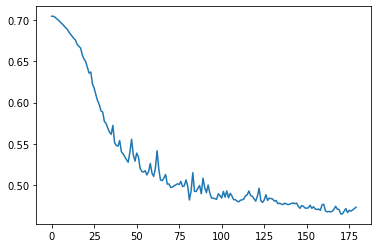

In [49]:
plt.plot(bce_overall_val_loss_list)

In [50]:
model_GRU_combined = GRU(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
first_bce_loss_function = torch.nn.BCELoss()
second_custom_loss_function = CustomLoss()
model_GRU_combined.to(device)

GRU(
  (gru): GRU(561, 8, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=8, out_features=4, bias=True)
  (linear_2): Linear(in_features=4, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [51]:
model_GRU_combined, (bce_loss_list, bce_acc_list, bce_overall_val_loss_list) = train_model(model_GRU_combined, first_bce_loss_function, 60, 5, 
                                    RNN_flag=True)


model_GRU_combined, (bce_loss_list, bce_acc_list, bce_overall_val_loss_list) = train_model(model_GRU_combined, second_custom_loss_function, 60, 5, 
                                    RNN_flag=True)

model_GRU_combined = model_GRU_combined.eval()
torch.save(model_GRU_combined, "experiments/model_GRU_combined.pth")

Epoch: 1/60... Step: 5... Loss: 0.686870... Val Loss: 0.686255
Epoch: 1/60... Step: 10... Loss: 0.683456... Val Loss: 0.681335
Epoch: 1/60... Step: 15... Loss: 0.685305... Val Loss: 0.679318
Epoch: 2/60... Step: 20... Loss: 0.680174... Val Loss: 0.677283
Epoch: 2/60... Step: 25... Loss: 0.674097... Val Loss: 0.674808
Epoch: 2/60... Step: 30... Loss: 0.684911... Val Loss: 0.673592
Epoch: 3/60... Step: 35... Loss: 0.682650... Val Loss: 0.670423
Epoch: 3/60... Step: 40... Loss: 0.669333... Val Loss: 0.666429
Epoch: 3/60... Step: 45... Loss: 0.662591... Val Loss: 0.663779
Epoch: 4/60... Step: 50... Loss: 0.655958... Val Loss: 0.659991
Epoch: 4/60... Step: 55... Loss: 0.657304... Val Loss: 0.658168
Epoch: 4/60... Step: 60... Loss: 0.659386... Val Loss: 0.657678
Epoch: 5/60... Step: 65... Loss: 0.646136... Val Loss: 0.653025
Epoch: 5/60... Step: 70... Loss: 0.658397... Val Loss: 0.648584
Epoch: 5/60... Step: 75... Loss: 0.656797... Val Loss: 0.646061
Epoch: 6/60... Step: 80... Loss: 0.636568

Epoch: 42/60... Step: 630... Loss: 0.483265... Val Loss: 0.506477
Epoch: 43/60... Step: 635... Loss: 0.455266... Val Loss: 0.506024
Epoch: 43/60... Step: 640... Loss: 0.458964... Val Loss: 0.496317
Epoch: 43/60... Step: 645... Loss: 0.526711... Val Loss: 0.509697
Epoch: 44/60... Step: 650... Loss: 0.548111... Val Loss: 0.503658
Epoch: 44/60... Step: 655... Loss: 0.541359... Val Loss: 0.504134
Epoch: 44/60... Step: 660... Loss: 0.482087... Val Loss: 0.565342
Epoch: 45/60... Step: 665... Loss: 0.537508... Val Loss: 0.518404
Epoch: 45/60... Step: 670... Loss: 0.436137... Val Loss: 0.498062
Epoch: 45/60... Step: 675... Loss: 0.551963... Val Loss: 0.496574
Epoch: 46/60... Step: 680... Loss: 0.488695... Val Loss: 0.506968
Epoch: 46/60... Step: 685... Loss: 0.417655... Val Loss: 0.540160
Epoch: 46/60... Step: 690... Loss: 0.456831... Val Loss: 0.506017
Epoch: 47/60... Step: 695... Loss: 0.448572... Val Loss: 0.502519
Epoch: 47/60... Step: 700... Loss: 0.524260... Val Loss: 0.518232
Epoch: 47/

Epoch: 23/60... Step: 345... Loss: -0.396366... Val Loss: -0.898631
Epoch: 24/60... Step: 350... Loss: -0.845458... Val Loss: -0.558073
Epoch: 24/60... Step: 355... Loss: -0.610205... Val Loss: -0.522849
Epoch: 24/60... Step: 360... Loss: -1.184396... Val Loss: -0.563002
Epoch: 25/60... Step: 365... Loss: -0.639624... Val Loss: -0.345761
Epoch: 25/60... Step: 370... Loss: -0.829752... Val Loss: -0.574301
Epoch: 25/60... Step: 375... Loss: -0.539679... Val Loss: -0.806859
Epoch: 26/60... Step: 380... Loss: -0.490378... Val Loss: -0.576854
Epoch: 26/60... Step: 385... Loss: -0.809997... Val Loss: -0.398079
Epoch: 26/60... Step: 390... Loss: -1.362033... Val Loss: -0.688633
Epoch: 27/60... Step: 395... Loss: -0.524625... Val Loss: -0.558920
Epoch: 27/60... Step: 400... Loss: -0.934195... Val Loss: -0.697338
Epoch: 27/60... Step: 405... Loss: -0.431668... Val Loss: 0.573469
Epoch: 28/60... Step: 410... Loss: -0.792622... Val Loss: -0.778672
Epoch: 28/60... Step: 415... Loss: -0.437835... V

# Calculate metrics for different models

In [52]:
def evaluate_metrics(y_true, y_pred, threshold=0.5):
    """
    Evaluate metrics for change point detection
    We assume, that there is no more than one change index in data (so, either 0 or 1 change)
    Inputs
    y_true : torch.Tensor
      true labels
    y_pred : torch.Tensor
      change probabiltiy
    threshold : float
      detection threshold
      
    Returns
    false_positive : int
      number of false positives
    false_negative : int
      number of false negatives
    delay : int
      detection delay
    accuracy : float
      y_pred accuracy given y_truei
    """
    delay = 0
    false_positive = 0
    false_negative = 0
    true_negative = 0

    index_real = torch.where(y_true != y_true[0])[0] # indexes with real changes
    index_detected = torch.where((y_pred > threshold).long() != y_true[0])[0] # indexes with predicted changes

    if len(index_real) > 0:
        real_change_index = index_real[0]

        if len(index_detected) > 0:
            index_sub_detected = torch.where(index_detected >= real_change_index)[0]

            if len(index_sub_detected) == len(index_detected):
                false_positive_delay = real_change_index.item()
                detected_change_index = index_detected[0]
                delay = (detected_change_index - real_change_index).item()
            else:
                false_positive_delay = index_detected[0].item()
                delay = 0
                false_positive += 1
                
        else:
            false_positive_delay = seq_len
            delay = (seq_len - real_change_index).item()
            false_negative += 1

    else:
        if len(index_detected) > 0:
            false_positive_delay = index_detected[0].item()
            false_positive += 1
        else:
            false_positive_delay = seq_len
            true_negative += 1
    
    accuracy = ((y_pred > threshold).long() == y_true).float().mean().item()
    
    return false_positive, false_negative, delay, false_positive_delay, accuracy

In [53]:
test_batch_size = 16

In [54]:
def get_quality_metrics(test_loader, model, threshold=0.5, LSTM_flag=False, RNN_flag=False):
    test_loss_list = []
    test_acc_list = []

    positive_number = 0 
    negative_number = 0
    fp_list = []
    fn_list = []
    delay_list = []
    fp_delay_list = []
    accuracy_list = []

    model.eval()
    for test_inputs, test_true_labels in test_loader:
            
        test_inputs, test_true_labels = test_inputs.to(device), test_true_labels.to(device)
        
        if LSTM_flag:
            test_hidden = model.init_hidden(test_batch_size)
            test_hidden = tuple([each.data for each in test_hidden])
            #test_hidden = torch.zeros(1, len(test_inputs), hidden_dim).to(device)
            #test_hidden = tuple([test_hidden, test_hidden])
            test_predictions, test_hidden = model(test_inputs, test_hidden)
        elif RNN_flag:
            test_hidden = torch.zeros(2, len(test_inputs), hidden_dim).to(device)
            test_predictions, test_hidden = model(test_inputs, test_hidden)            
        else:
            test_predictions = model(test_inputs)
            
        test_loss = loss_function(test_predictions.squeeze(), test_true_labels.float())
        test_loss_list += [test_loss.cpu().clone().detach()]

        for i in range(0, test_batch_size):
            curr_labels = test_true_labels[i]
            curr_predictions = test_predictions[i]
            
            # torch.rand_like
            curr_fp, curr_fn, curr_delay, curr_fp_delay, curr_accuracy = evaluate_metrics(curr_labels, curr_predictions, 
                                                                           threshold)

            max_difference = np.abs((curr_labels.max() - curr_labels.min()).item())
            if max_difference: 
                delay_list.append(curr_delay)
            positive_number += (max_difference > 0)
            negative_number += 1 - (max_difference > 0)

            fp_list.append(curr_fp)
            fn_list.append(curr_fn)
            fp_delay_list.append(curr_fp_delay)
            accuracy_list.append(curr_accuracy)

        test_acc_list.append(np.mean(accuracy_list[-test_batch_size:]))
        
    return (positive_number, negative_number, np.mean(test_loss_list), np.mean(test_acc_list), np.mean(delay_list),
            np.mean(fp_delay_list), np.sum(fp_list), np.sum(fn_list))

In [55]:
def get_pareto_metrics_for_threshold(model, test_loader, threshold_list, LSTM_flag=False, RNN_flag=False):
    fp_number_list = []
    fn_number_list = []
    delay_list = []
    fp_delay_list = []
    for threshold in threshold_list:
        # test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, batch_size)

        (positive_number, negative_number, test_loss, 
         test_acc, mean_delay, mean_fp_delay, fp_number, fn_number) = get_quality_metrics(test_loader, model, threshold, LSTM_flag, RNN_flag)

        fp_number_list.append(fp_number)
        fn_number_list.append(fn_number)
        delay_list.append(mean_delay)
        fp_delay_list.append(mean_fp_delay)
        #print(threshold, fp_number, fn_number, mean_delay, mean_fp_delay)
    
    return fp_number_list, fn_number_list, delay_list, fp_delay_list

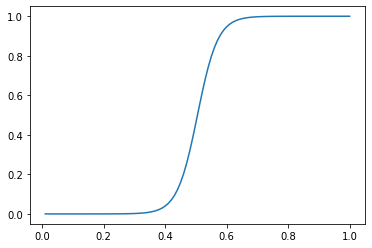

In [56]:
threshold_number = 100
threshold_list = np.linspace(-15, 15, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
#threshold_list = np.append([-0.01], threshold_list)
#threshold_list = np.append(threshold_list, [1.01])
plt.plot(np.linspace(0.01, 1, threshold_number), threshold_list)

### Evaluate LSTM

In [167]:
model_LSTM_bce = torch.load("experiments/model_LSTM_bce.pth")
model_LSTM_custom = torch.load("experiments/model_LSTM_custom.pth")
model_LSTM_combined = torch.load("experiments/model_LSTM_combined.pth")

In [38]:
test_batch_size = 4
loss_function = torch.nn.BCELoss()
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_LSTM_bce, fn_number_list_LSTM_bce, 
 delay_list_LSTM_bce, fp_delay_list_LSTM_bce) = get_pareto_metrics_for_threshold(model_LSTM_bce, final_test_loader, 
                                                                                 threshold_list, LSTM_flag=True)

In [39]:
test_batch_size = 4
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_LSTM_custom, fn_number_list_LSTM_custom, 
 delay_list_LSTM_custom, fp_delay_list_LSTM_custom) = get_pareto_metrics_for_threshold(model_LSTM_custom, final_test_loader, 
                                                                                       threshold_list, LSTM_flag=True)

In [40]:
test_batch_size = 4
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_LSTM_combined, fn_number_list_LSTM_combined, delay_list_LSTM_combined, fp_delay_list_LSTM_combined) = get_pareto_metrics_for_threshold(model_LSTM_combined, final_test_loader, threshold_list, LSTM_flag=True)

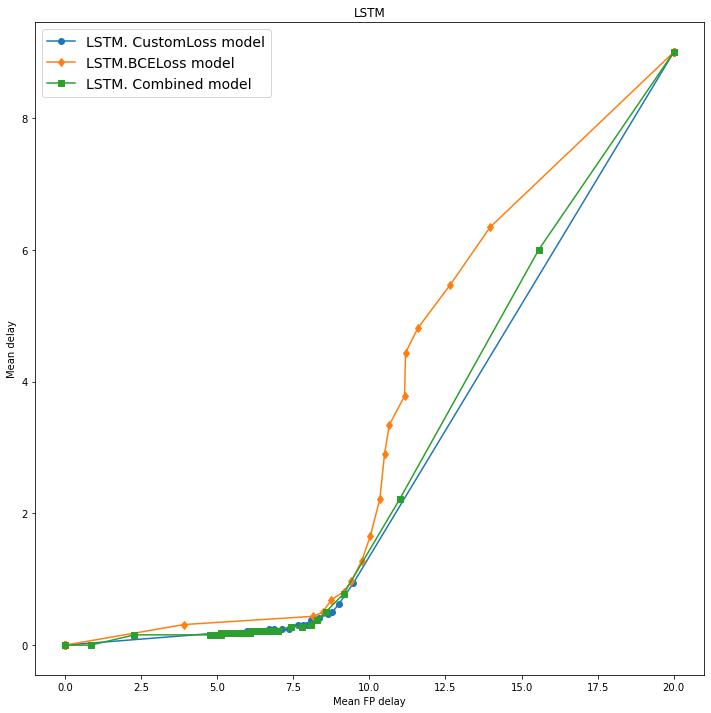

In [41]:
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list_LSTM_custom, delay_list_LSTM_custom, '-o', label='LSTM. CustomLoss model')
plt.plot(np.array(fp_delay_list_LSTM_bce), np.array(delay_list_LSTM_bce), '-d', label='LSTM.BCELoss model')
plt.plot(fp_delay_list_LSTM_combined, delay_list_LSTM_combined, '-s', label='LSTM. Combined model')

plt.xlabel('Mean FP delay')
plt.ylabel('Mean delay')
plt.title('LSTM')
#plt.yscale('log')
plt.legend(loc='upper left', fontsize=14);

### Evaluate GRU

In [ ]:
model_GRU_bce = torch.load("experiments/model_GRU_bce.pth")
model_GRU_custom = torch.load("experiments/model_GRU_custom.pth")
model_GRU_combined = torch.load("experiments/model_GRU_combined.pth")

In [57]:
test_batch_size = 4
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_GRU_bce, fn_number_list_GRU_bce, 
 delay_list_GRU_bce, fp_delay_list_GRU_bce) = get_pareto_metrics_for_threshold(model_GRU_bce, final_test_loader, 
                                                                                 threshold_list, RNN_flag=True)

In [58]:
test_batch_size = 4
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_GRU_custom, fn_number_list_GRU_custom, 
 delay_list_GRU_custom, fp_delay_list_GRU_custom) = get_pareto_metrics_for_threshold(model_GRU_custom, final_test_loader, 
                                                                                       threshold_list, RNN_flag=True)

In [59]:
test_batch_size = 4
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_GRU_combined, fn_number_list_GRU_combined, delay_list_GRU_combined, fp_delay_list_GRU_combined) = get_pareto_metrics_for_threshold(model_GRU_combined, final_test_loader, threshold_list, RNN_flag=True)

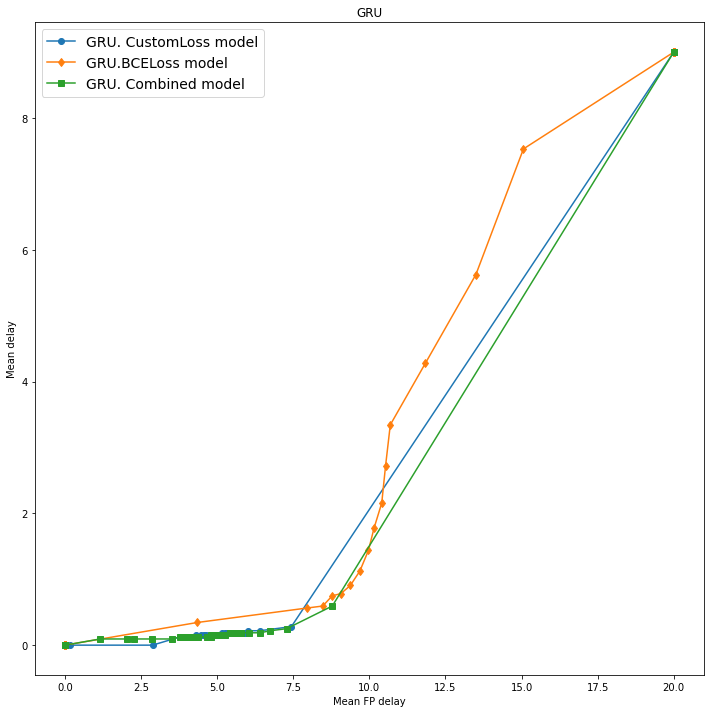

In [60]:
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list_GRU_custom, delay_list_GRU_custom, '-o', label='GRU. CustomLoss model')
plt.plot(fp_delay_list_GRU_bce, delay_list_GRU_bce, '-d', label='GRU.BCELoss model')
plt.plot(fp_delay_list_GRU_combined, delay_list_GRU_combined, '-s', label='GRU. Combined model')

plt.xlabel('Mean FP delay')
plt.ylabel('Mean delay')
plt.title('GRU')
#plt.yscale('log')
plt.legend(loc='upper left', fontsize=14);

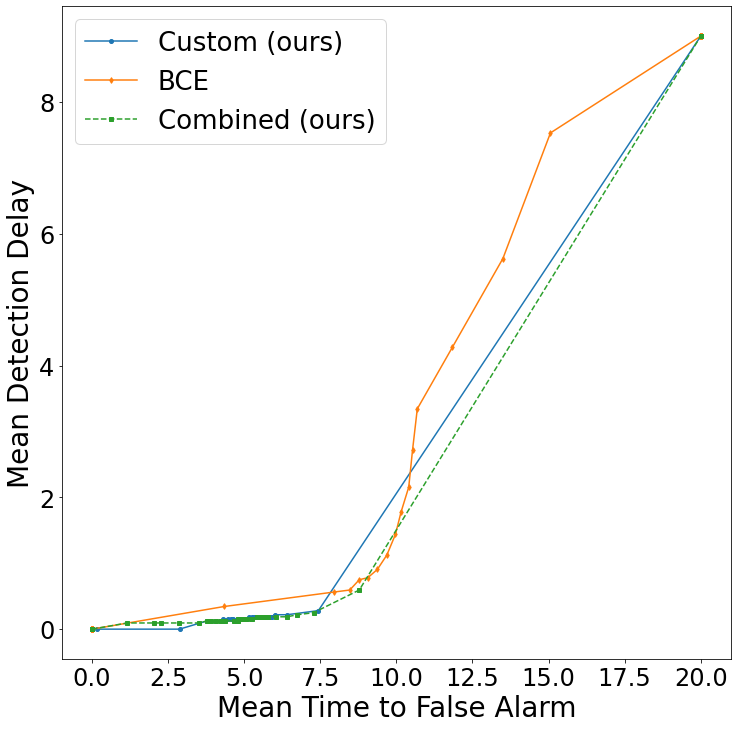

In [64]:
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list_GRU_custom, delay_list_GRU_custom, '-o', markersize=4, label='Custom (ours)')
plt.plot(fp_delay_list_GRU_bce, delay_list_GRU_bce, '-d', markersize=4, label='BCE')
plt.plot(fp_delay_list_GRU_combined, delay_list_GRU_combined, '--s', markersize=4, label='Combined (ours)')

plt.xlabel('Mean Time to False Alarm', fontsize=28)
plt.ylabel('Mean Detection Delay', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc='upper left', fontsize=26);
plt.savefig('ha_GRU.pdf', bbox_inches='tight')

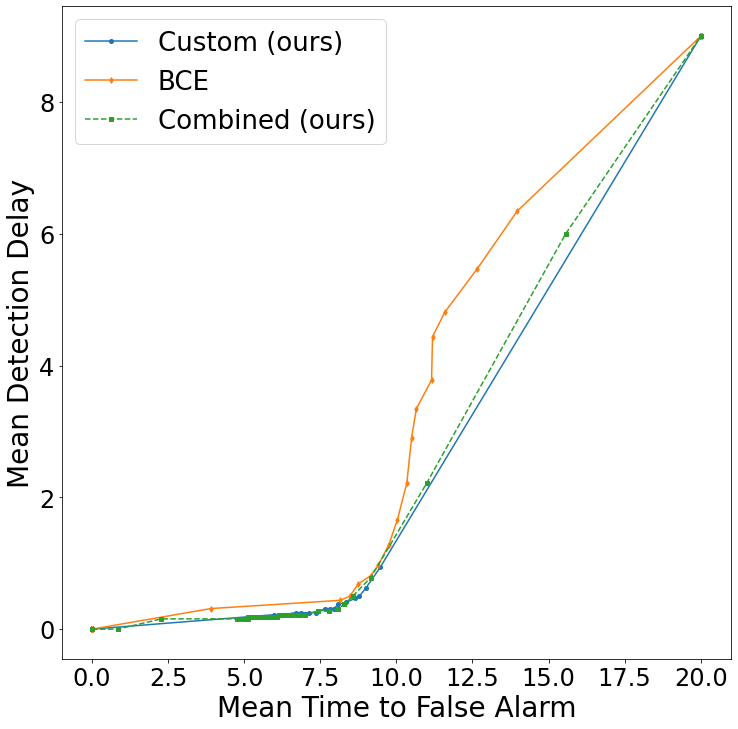

In [63]:
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list_LSTM_custom, delay_list_LSTM_custom, '-o', markersize=4, label='Custom (ours)')
plt.plot(fp_delay_list_LSTM_bce, delay_list_LSTM_bce, '-d', markersize=4, label='BCE')
plt.plot(fp_delay_list_LSTM_combined, delay_list_LSTM_combined, '--s', markersize=4, label='Combined (ours)')

plt.xlabel('Mean Time to False Alarm', fontsize=28)
plt.ylabel('Mean Detection Delay', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc='upper left', fontsize=26);
plt.savefig('ha_LSTM.pdf', bbox_inches='tight')

In [83]:
print('LSTM_custom: ', metrics_v4.area_under_graph(delay_list_LSTM_custom, fp_delay_list_LSTM_custom))
print('LSTM_bce: ', metrics_v4.area_under_graph(delay_list_LSTM_bce, fp_delay_list_LSTM_bce))
print('LSTM_combined: ', metrics_v4.area_under_graph(delay_list_LSTM_combined, fp_delay_list_LSTM_combined)) 

print('\n')

print('GRU_custom: ', metrics_v4.area_under_graph(delay_list_GRU_custom, fp_delay_list_GRU_custom))
print('GRU_bce: ', metrics_v4.area_under_graph(delay_list_GRU_bce, fp_delay_list_GRU_bce))
print('GRU_combined: ', metrics_v4.area_under_graph(delay_list_GRU_combined, fp_delay_list_GRU_combined))  

LSTM_custom:  54.3203125
LSTM_bce:  68.6123046875
LSTM_combined:  56.59814453125


GRU_custom:  59.0615234375
GRU_bce:  69.32275390625
GRU_combined:  55.35888671875


In [85]:
%load_ext autoreload
%autoreload 1
%aimport metrics_v4
import metrics_v4

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
metrics_v4.save_metrics_to_file_new_version('LSTM_custom', 
                                 model_LSTM_custom, 
                                 final_test_loader, 
                                 batch_size=4,
                                 seq_len=20,
                                 fp_delay = fp_delay_list_LSTM_custom,
                                 threshold_list=threshold_list,
                                 x_coord_arr = [4, 4.9, 6, 7, 8, 9, 10, 11, 12],
                                 lstm_flag=True,
                                 rnn_flag=False,
                                 path_to_save='experiments/'
                                 )

0.0 0.31917282672147035 5.96875 0.388280588592839 4
TP: 1 TN: 0 FP: 31 FN: 0 DELAY: 0.21875 FP_DELAY 5.625
0.21875 !!!!!!!!
0.0 0.31917282672147035 5.96875 0.388280588592839 4.9
TP: 1 TN: 0 FP: 31 FN: 0 DELAY: 0.21875 FP_DELAY 5.78125
0.21875 !!!!!!!!
5.96875 0.388280588592839 6.28125 0.46219351092684924 6
TP: 1 TN: 0 FP: 31 FN: 0 DELAY: 0.21875 FP_DELAY 6.0
0.21875 !!!!!!!!
6.875 0.6117194114071615 7.125 0.6808271732785297 7
TP: 3 TN: 0 FP: 29 FN: 0 DELAY: 0.25 FP_DELAY 7.0
0.25 !!!!!!!!
7.9375 0.877578561013787 8.09375 0.9065929952831678 8
TP: 5 TN: 0 FP: 27 FN: 0 DELAY: 0.3125 FP_DELAY 8.03125
0.3125 !!!!!!!!
9.0 0.9702535746159258 9.46875 0.977857796041868 9
TP: 13 TN: 0 FP: 19 FN: 0 DELAY: 0.625 FP_DELAY 9.0
0.625 !!!!!!!!
9.46875 0.977857796041868 20.0 0.9835510693065821 10
TP: 18 TN: 0 FP: 14 FN: 0 DELAY: 0.9375 FP_DELAY 9.46875
0.9375 !!!!!!!!
9.46875 0.977857796041868 20.0 0.9835510693065821 11
TP: 18 TN: 0 FP: 14 FN: 0 DELAY: 1.0625 FP_DELAY 9.53125
1.0625 !!!!!!!!
9.46875 0.